In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import matplotlib.pyplot as plt
import os
import socket
import time
import random
import glob
import argparse, json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

"""
    IMPORTING CUSTOM MODULES/METHODS
"""
from nets.molecules_graph_regression.load_net import gnn_model 
from data.data import LoadData 

Using backend: pytorch


In [2]:
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
        print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('cuda not available')
        device = torch.device("cpu")
    return device


"""
    VIEWING MODEL CONFIG AND PARAMS
"""
def view_model_param(MODEL_NAME, net_params):
    model = gnn_model(MODEL_NAME, net_params)
    total_param = 0
    print("MODEL DETAILS:\n")
    #print(model)
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    print('MODEL/Total parameters:', MODEL_NAME, total_param)
    return total_param

"""
    TRAINING CODE
"""

def train_val_pipeline(MODEL_NAME, dataset, params, net_params, dirs):

    t0 = time.time()
    per_epoch_time = []
        
    DATASET_NAME = dataset.name
    
    if net_params['lap_pos_enc']:
        st = time.time()
        print("[!] Adding Laplacian positional encoding.")
        dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
        print('Time LapPE:',time.time()-st)
        
    if net_params['wl_pos_enc']:
        st = time.time()
        print("[!] Adding WL positional encoding.")
        dataset._add_wl_positional_encodings()
        print('Time WL PE:',time.time()-st)
    
    if net_params['full_graph']:
        st = time.time()
        print("[!] Converting the given graphs to full graphs..")
        dataset._make_full_graph()
        print('Time taken to convert to full graphs:',time.time()-st)    
        
    trainset, valset, testset = dataset.train, dataset.val, dataset.test
        
    root_log_dir, root_ckpt_dir, write_file_name, write_config_file = dirs
    device = net_params['device']
    
    # Write the network and optimization hyper-parameters in folder config/
    with open(write_config_file + '.txt', 'w') as f:
        f.write("""Dataset: {},\nModel: {}\n\nparams={}\n\nnet_params={}\n\n\nTotal Parameters: {}\n\n"""                .format(DATASET_NAME, MODEL_NAME, params, net_params, net_params['total_param']))
        
    log_dir = os.path.join(root_log_dir, "RUN_" + str(0))
    writer = SummaryWriter(log_dir=log_dir)

    # setting seeds
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    if device.type == 'cuda':
        torch.cuda.manual_seed(params['seed'])
    
    print("Training Graphs: ", len(trainset))
    print("Validation Graphs: ", len(valset))
    print("Test Graphs: ", len(testset))

    model = gnn_model(MODEL_NAME, net_params)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['init_lr'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=params['lr_reduce_factor'],
                                                     patience=params['lr_schedule_patience'],
                                                     verbose=True)
    
    epoch_train_losses, epoch_val_losses = [], []
    epoch_train_MAEs, epoch_val_MAEs = [], [] 
    scores = []

    # import train and evaluate functions
    from train.EA_train_molecules_graph_regression import train_epoch, evaluate_network

    train_loader = DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, collate_fn=dataset.collate)
    val_loader = DataLoader(valset, batch_size=params['batch_size'], shuffle=False, collate_fn=dataset.collate)
    test_loader = DataLoader(testset, batch_size=params['batch_size'], shuffle=False, collate_fn=dataset.collate)
    
    # At any point you can hit Ctrl + C to break out of training early.
    try:
        with tqdm(range(params['epochs'])) as t:
            for epoch in t:

                t.set_description('Epoch %d' % epoch)

                start = time.time()

                epoch_train_loss, epoch_train_mae, optimizer, scores_epoch = train_epoch(model, optimizer, device, train_loader, epoch)
                    
                epoch_val_loss, epoch_val_mae = evaluate_network(model, device, val_loader, epoch)
                _, epoch_test_mae = evaluate_network(model, device, test_loader, epoch)
                
                if epoch%10==0:
                    scores.append(scores_epoch)
                
                epoch_train_losses.append(epoch_train_loss)
                epoch_val_losses.append(epoch_val_loss)
                epoch_train_MAEs.append(epoch_train_mae)
                epoch_val_MAEs.append(epoch_val_mae)

                writer.add_scalar('train/_loss', epoch_train_loss, epoch)
                writer.add_scalar('val/_loss', epoch_val_loss, epoch)
                writer.add_scalar('train/_mae', epoch_train_mae, epoch)
                writer.add_scalar('val/_mae', epoch_val_mae, epoch)
                writer.add_scalar('test/_mae', epoch_test_mae, epoch)
                writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)

                        
                t.set_postfix(time=time.time()-start, lr=optimizer.param_groups[0]['lr'],
                              train_loss=epoch_train_loss, val_loss=epoch_val_loss,
                              train_MAE=epoch_train_mae, val_MAE=epoch_val_mae,
                              test_MAE=epoch_test_mae)


                per_epoch_time.append(time.time()-start)

                # Saving checkpoint
                ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
                if not os.path.exists(ckpt_dir):
                    os.makedirs(ckpt_dir)
                torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))

                files = glob.glob(ckpt_dir + '/*.pkl')
                for file in files:
                    epoch_nb = file.split('_')[-1]
                    epoch_nb = int(epoch_nb.split('.')[0])
                    if epoch_nb < epoch-1:
                        os.remove(file)

                scheduler.step(epoch_val_loss)

                if optimizer.param_groups[0]['lr'] < params['min_lr']:
                    print("\n!! LR EQUAL TO MIN LR SET.")
                    break
                
                # Stop training after params['max_time'] hours
                if time.time()-t0 > params['max_time']*3600:
                    print('-' * 89)
                    print("Max_time for training elapsed {:.2f} hours, so stopping".format(params['max_time']))
                    break
                
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early because of KeyboardInterrupt')
    
    _, test_mae = evaluate_network(model, device, test_loader, epoch)
    _, train_mae = evaluate_network(model, device, train_loader, epoch)
    print("Test MAE: {:.4f}".format(test_mae))
    print("Train MAE: {:.4f}".format(train_mae))
    print("Convergence Time (Epochs): {:.4f}".format(epoch))
    print("TOTAL TIME TAKEN: {:.4f}s".format(time.time()-t0))
    print("AVG TIME PER EPOCH: {:.4f}s".format(np.mean(per_epoch_time)))
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25,15))
    for i in range(2):
        for j in range(5):
            axs[i,j].hist(scores[j + i*5])
            axs[i,j].set_title('Epoch '+str((j + i*5)*10))
    writer.close()

    """
        Write the results in out_dir/results folder
    """
    with open(write_file_name + '.txt', 'w') as f:
        f.write("""Dataset: {},\nModel: {}\n\nparams={}\n\nnet_params={}\n\n{}\n\nTotal Parameters: {}\n\n
    FINAL RESULTS\nTEST MAE: {:.4f}\nTRAIN MAE: {:.4f}\n\n
    Convergence Time (Epochs): {:.4f}\nTotal Time Taken: {:.4f} hrs\nAverage Time Per Epoch: {:.4f} s\n\n\n"""\
          .format(DATASET_NAME, MODEL_NAME, params, net_params, model, net_params['total_param'],
                  test_mae, train_mae, epoch, (time.time()-t0)/3600, np.mean(per_epoch_time)))

In [3]:
"""
    USER CONTROLS
"""

config = open('configs/molecules_GraphTransformer_LapPE_ZINC_500k_sparse_graph_BN.json')
config = json.load(config)

In [4]:
def main():    
    
    device = gpu_setup(True, 0)
    
    # model, dataset, out_dir
    MODEL_NAME = config['model']
    DATASET_NAME = config['dataset']
    dataset = LoadData(DATASET_NAME)
    out_dir = config['out_dir']
    
    # parameters
    params = config['params']
    
    # modif
    
    params['epochs'] = 100
    
    # end modif
    
    # network parameters
    net_params = config['net_params']
    net_params['device'] = device
    net_params['gpu_id'] = config['gpu']['id']
    net_params['batch_size'] = params['batch_size']
    
    # modif
    
    net_params['layer_norm'] = True
    net_params['batch_norm'] = False
    
    # end modif
    
    # ZINC
    net_params['num_atom_type'] = dataset.num_atom_type
    net_params['num_bond_type'] = dataset.num_bond_type
    
    root_log_dir = out_dir + 'logs/' + MODEL_NAME + "_EA_norm_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    root_ckpt_dir = out_dir + 'checkpoints/' + MODEL_NAME + "_EA_norm_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    write_file_name = out_dir + 'results/result_' + MODEL_NAME + "_EA_norm_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    write_config_file = out_dir + 'configs/config_' + MODEL_NAME + "_norm" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    dirs = root_log_dir, root_ckpt_dir, write_file_name, write_config_file

    if not os.path.exists(out_dir + 'results'):
        os.makedirs(out_dir + 'results')
        
    if not os.path.exists(out_dir + 'configs'):
        os.makedirs(out_dir + 'configs')

    net_params['total_param'] = view_model_param(MODEL_NAME, net_params)
    train_val_pipeline(MODEL_NAME, dataset, params, net_params, dirs)

cuda available with GPU: Quadro P2000
[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 4.2830s
MODEL DETAILS:

MODEL/Total parameters: GraphTransformer 588929
[!] Adding Laplacian positional encoding.


/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.adjacency_matrix_scipy is deprecated. Please replace it with:

	DGLGraph.adjacency_matrix(transpose, scipy_fmt="csr").

  return warnings.warn(message, category=category, stacklevel=1)


Time LapPE: 15.171566009521484
Training Graphs:  10000
Validation Graphs:  1000
Test Graphs:  1000


Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]


 @ Epoch 0 ------- 

 Showing 
 - 35th element out of 128 
 - in batch 64 out of 78



/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


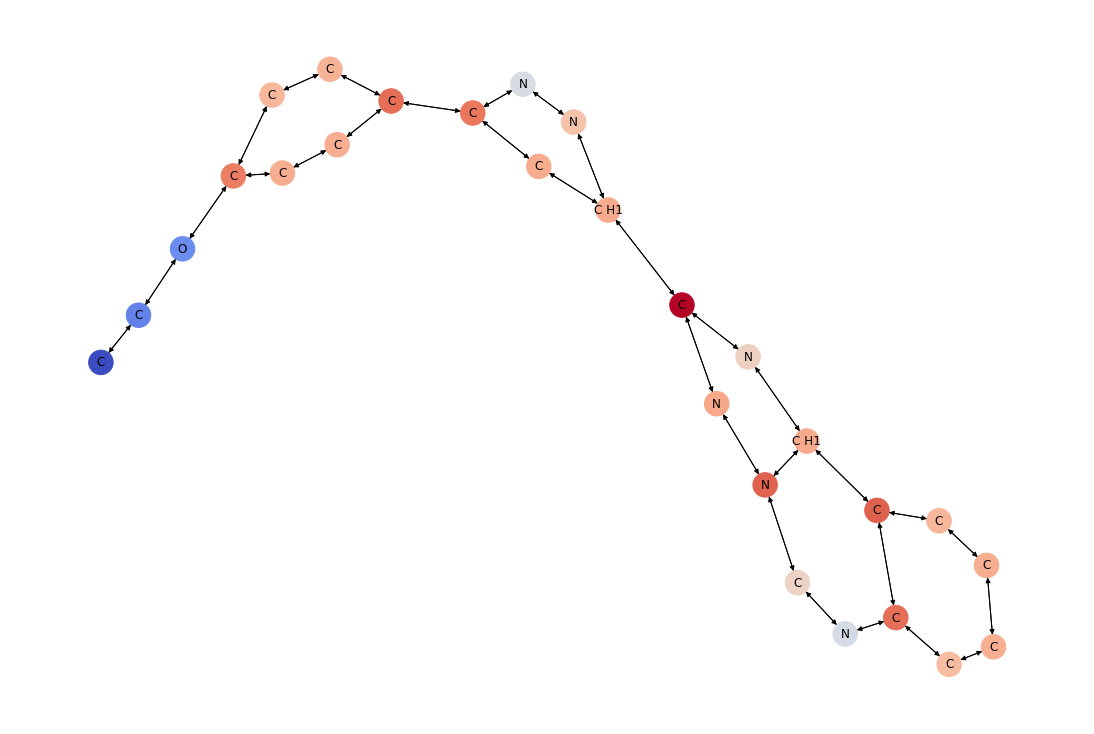


 Values of scores : 
 [0.22814605 0.43770325 0.4817559  1.5692446  1.3288586  1.348598
 1.6229366  1.5860175  1.3838221  1.3895285  1.8741406  1.4028046
 1.6608362  1.1575963  0.99505746 1.6187346  1.3078675  1.3725125
 1.3759339  1.3401225  1.6625042  1.3899825  1.1747859  1.2683578
 1.0177188  1.378869   1.3772638 ] 

 _________ 


Expected solubility : 2.3868987560272217 .
Solubility predicted : 1.422519564628601 . 

 --------------------------------------------------




Epoch 10:  10%|█         | 10/100 [02:21<21:33, 14.37s/it, lr=0.0007, test_MAE=0.501, time=14.7, train_MAE=0.453, train_loss=0.453, val_MAE=0.45, val_loss=0.45]


 @ Epoch 10 ------- 

 Showing 
 - 82th element out of 128 
 - in batch 42 out of 78



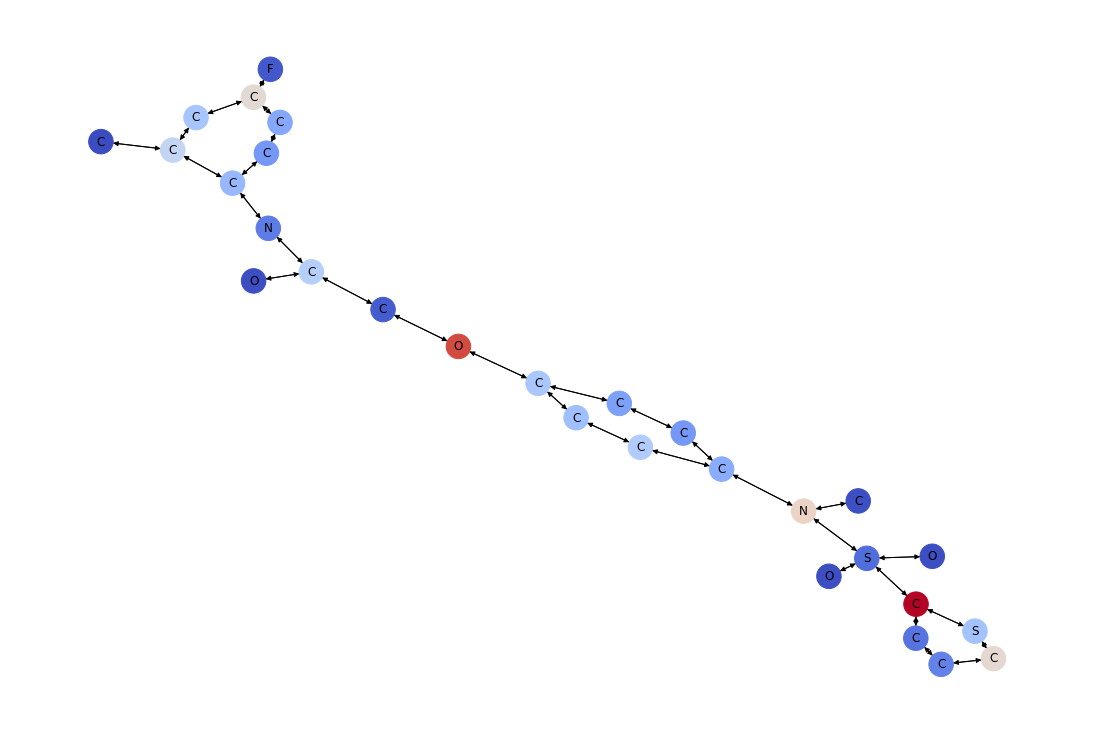


 Values of scores : 
 [ 0.16839409 25.215988   20.17647    32.209915    2.0458417  14.166864
 11.168115   17.149336    6.8680806  22.671524    0.6386933   2.4357305
 55.749866   20.641537   12.689244   11.298401   14.929497   34.464046
  0.7436911   4.8513055   0.5682604   0.5682604  61.230923    5.827422
  7.8108253  32.78828    19.402803   21.66959    18.58987   ] 

 _________ 


Expected solubility : -0.5974013209342957 .
Solubility predicted : -1.0289918184280396 . 

 --------------------------------------------------




Epoch 20:  20%|██        | 20/100 [04:39<18:16, 13.71s/it, lr=0.0007, test_MAE=0.444, time=13.9, train_MAE=0.381, train_loss=0.381, val_MAE=0.395, val_loss=0.395]


 @ Epoch 20 ------- 

 Showing 
 - 31th element out of 128 
 - in batch 71 out of 78



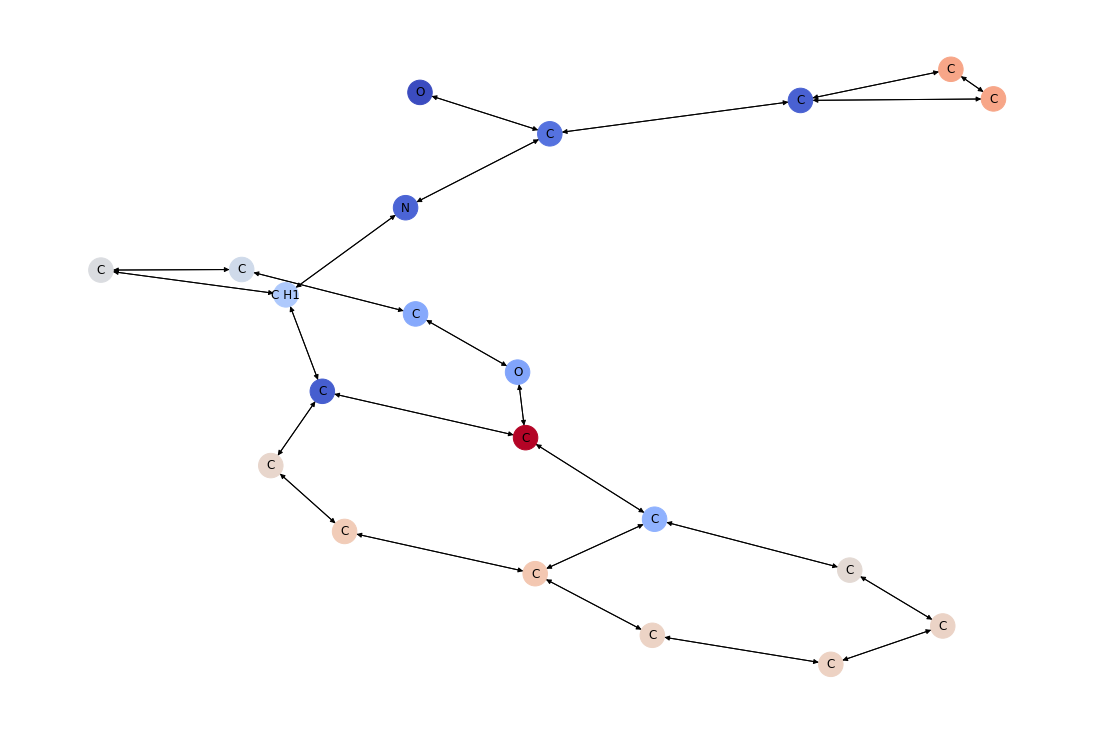


 Values of scores : 
 [ 0.9745594  7.4591503  5.004771  25.999094  36.7501    33.792816
 18.008232  16.732231  73.702126   3.989778  40.72603   44.346863
 45.763138  41.90726   42.21871   41.6186    39.137127  19.789726
  4.4829206 53.107956  53.107956 ] 

 _________ 


Expected solubility : -2.534473419189453 .
Solubility predicted : -2.5259222984313965 . 

 --------------------------------------------------




Epoch 30:  30%|███       | 30/100 [07:00<16:25, 14.08s/it, lr=0.0007, test_MAE=0.421, time=14.4, train_MAE=0.326, train_loss=0.326, val_MAE=0.377, val_loss=0.377]


 @ Epoch 30 ------- 

 Showing 
 - 118th element out of 128 
 - in batch 33 out of 78



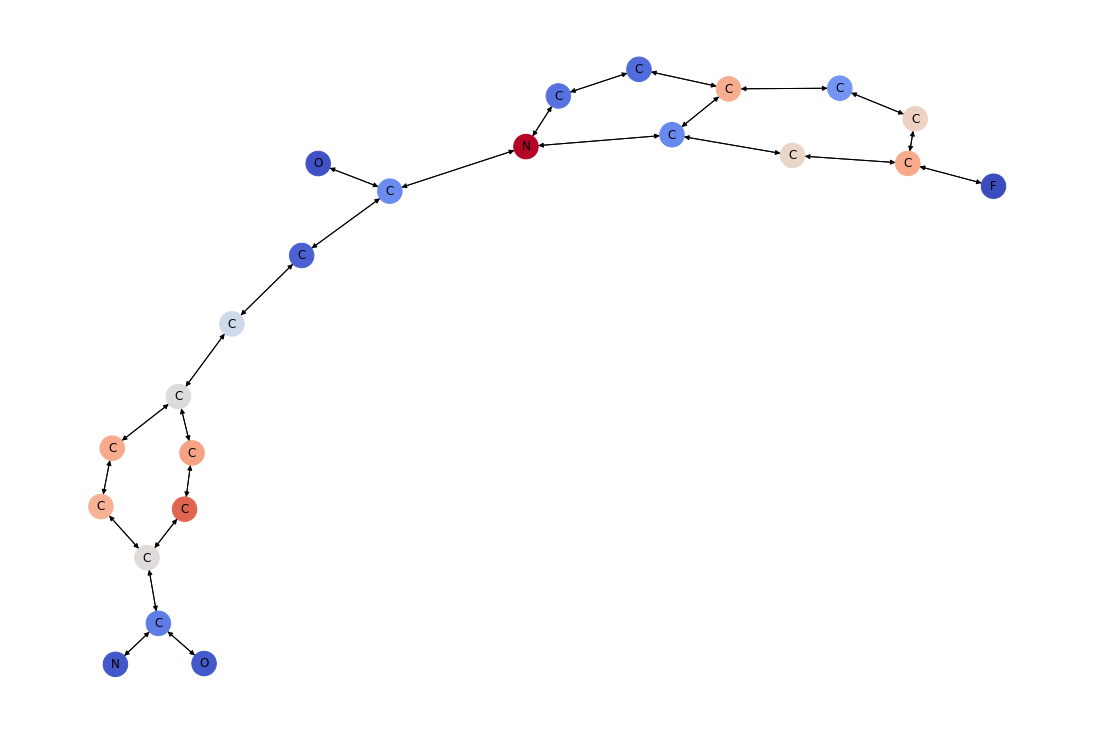


 Values of scores : 
 [ 1.747231   7.4677587  2.4463139 33.507023  56.734898  47.44608
 33.161762  29.44218    3.4760385 10.134611   1.1298335 65.44446
  5.9865446  5.0092688 45.818108  11.5707445 37.585968  46.472687
  0.2122398 36.25519    9.658571  46.282448  44.86644  ] 

 _________ 


Expected solubility : -0.3433220684528351 .
Solubility predicted : -0.12078458070755005 . 

 --------------------------------------------------




Epoch 40:  40%|████      | 40/100 [09:17<13:38, 13.64s/it, lr=0.0007, test_MAE=0.415, time=13.4, train_MAE=0.296, train_loss=0.296, val_MAE=0.369, val_loss=0.369]


 @ Epoch 40 ------- 

 Showing 
 - 38th element out of 128 
 - in batch 40 out of 78



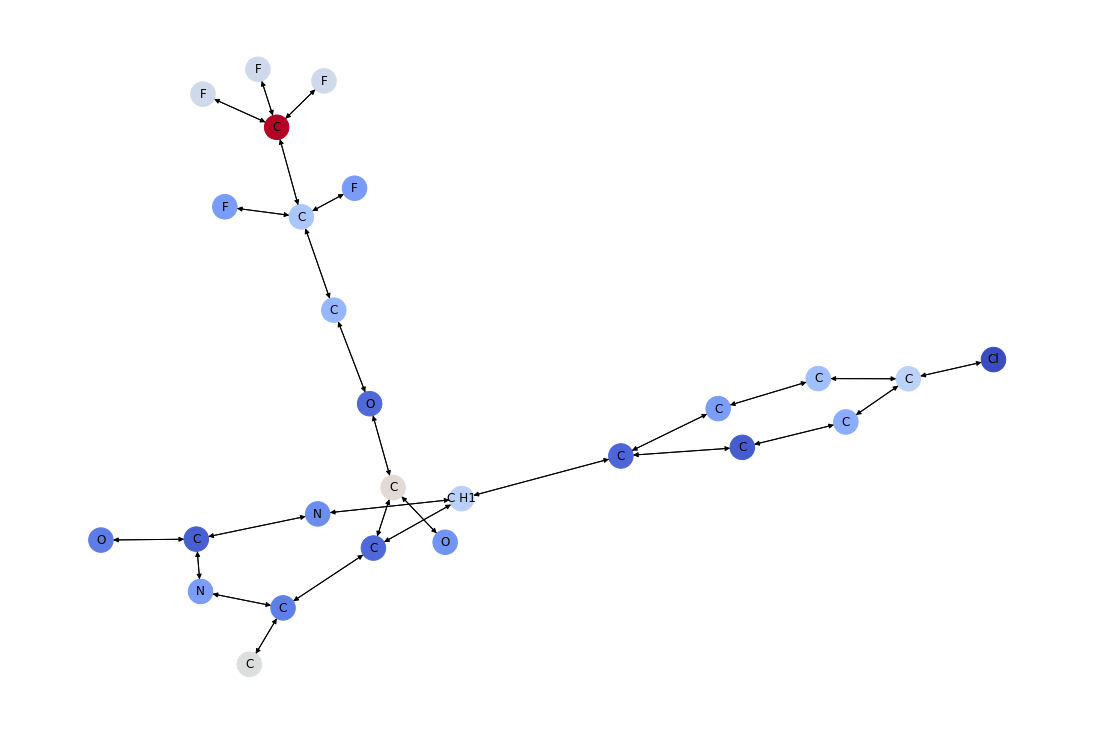


 Values of scores : 
 [ 61.086872    14.953347     8.351242    63.76288     21.526978
   8.476647    33.60133     40.933136    23.583832    23.583832
 122.31764     54.705894    54.705894    54.705894    46.661514
   7.8227468   24.10911     37.341057    47.553337     0.18998855
  29.877234     4.9012136   19.197826     5.690099    13.612392
  24.501682  ] 

 _________ 


Expected solubility : -0.46894651651382446 .
Solubility predicted : -0.41141149401664734 . 

 --------------------------------------------------




Epoch 50:  50%|█████     | 50/100 [11:34<11:24, 13.69s/it, lr=0.0007, test_MAE=0.385, time=13.4, train_MAE=0.264, train_loss=0.264, val_MAE=0.354, val_loss=0.354]


 @ Epoch 50 ------- 

 Showing 
 - 52th element out of 128 
 - in batch 23 out of 78



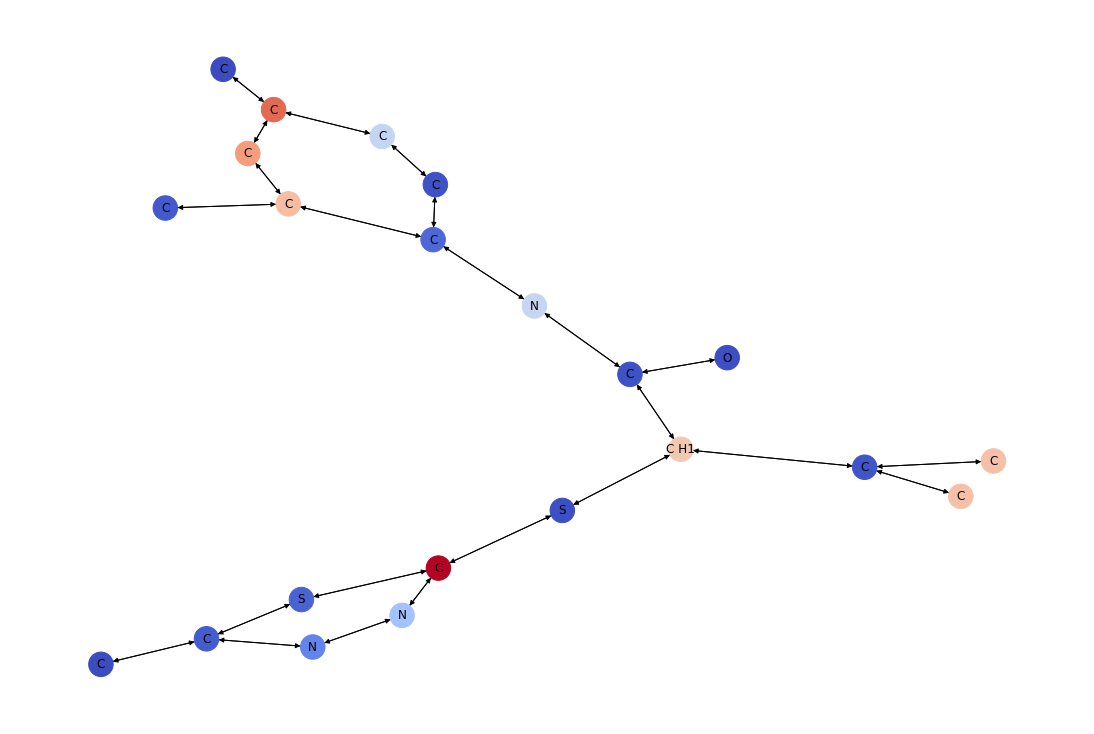


 Values of scores : 
 [ 0.84678966 82.412674   39.721672    2.0291753   6.6130066  40.660896
  1.7401502   1.2367563  58.907795    1.6659052  95.91177    30.540714
 12.938018    4.0374346   0.56476724  5.430908    2.5553396  61.59765
 61.59765    62.55341     3.6247125  71.334015  ] 

 _________ 


Expected solubility : -0.40910521149635315 .
Solubility predicted : -0.14669910073280334 . 

 --------------------------------------------------




Epoch 60:  60%|██████    | 60/100 [13:50<09:02, 13.56s/it, lr=0.0007, test_MAE=0.364, time=13.5, train_MAE=0.234, train_loss=0.234, val_MAE=0.339, val_loss=0.339]


 @ Epoch 60 ------- 

 Showing 
 - 101th element out of 128 
 - in batch 29 out of 78



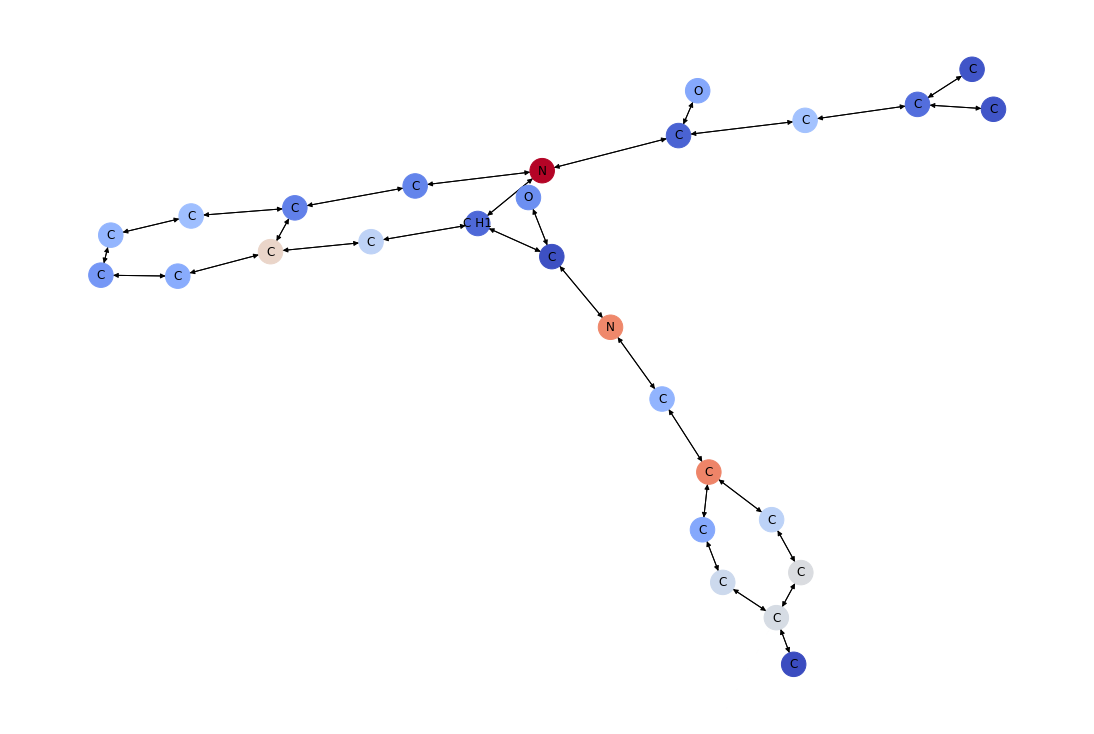


 Values of scores : 
 [ 0.4505815 42.62367   44.09337   35.195576  71.767296  24.041769
 71.11522    1.438461  14.64292    6.2412157 35.429527  49.813248
 21.973814  16.53831   24.20238   27.36969   11.408652  11.961891
 89.64613    5.058998  20.70727   28.522392   7.7010975  2.2947686
  2.2947686 20.858856  39.689552 ] 

 _________ 


Expected solubility : 1.6856913566589355 .
Solubility predicted : 1.66023588180542 . 

 --------------------------------------------------




Epoch 70:  70%|███████   | 70/100 [16:07<06:44, 13.49s/it, lr=0.0007, test_MAE=0.344, time=13.4, train_MAE=0.226, train_loss=0.226, val_MAE=0.339, val_loss=0.339]


 @ Epoch 70 ------- 

 Showing 
 - 97th element out of 128 
 - in batch 33 out of 78



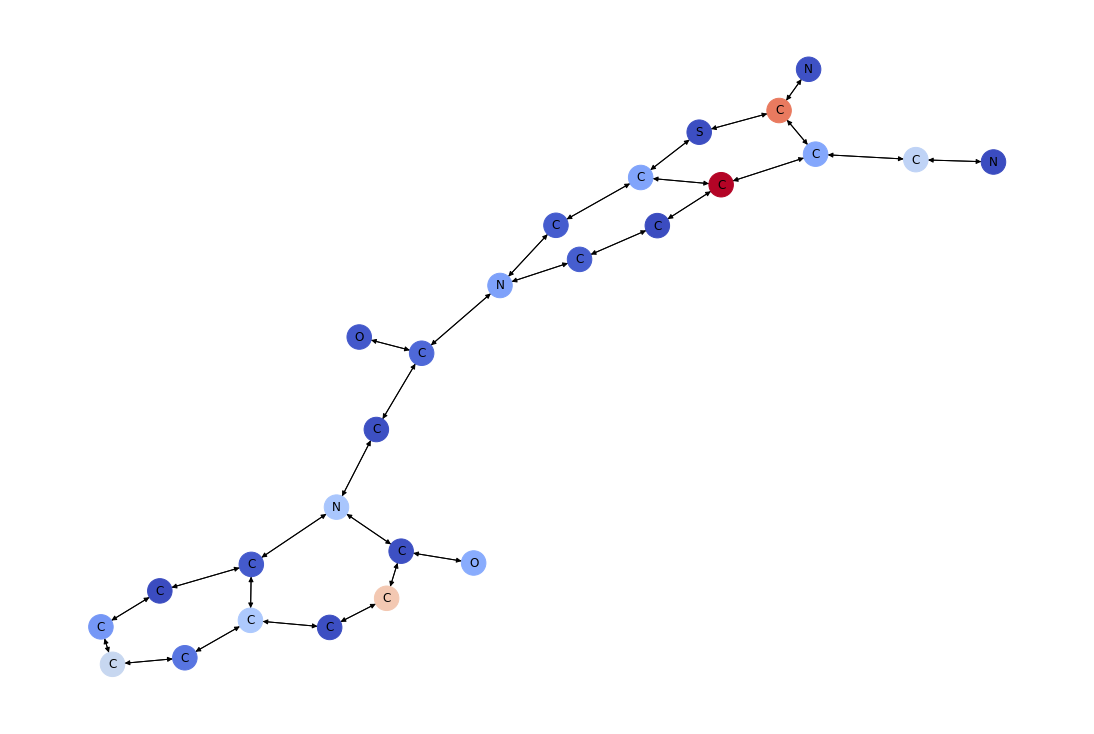


 Values of scores : 
 [  2.4131315  44.726242   26.316813   90.31326     3.46979     2.7337506
  25.576714  109.21793     2.1960778   6.465146   24.640877    8.927528
   5.1746116   3.2803771  37.36958     3.2506304  27.973656   67.62988
   2.9432902  38.865875   12.491528   47.475143   21.823051    2.2341652
   5.8987703   6.3392916] 

 _________ 


Expected solubility : -0.09153369814157486 .
Solubility predicted : -0.06286740303039551 . 

 --------------------------------------------------




Epoch 80:  80%|████████  | 80/100 [18:23<04:31, 13.58s/it, lr=0.0007, test_MAE=0.347, time=13.3, train_MAE=0.22, train_loss=0.22, val_MAE=0.344, val_loss=0.344]  


 @ Epoch 80 ------- 

 Showing 
 - 84th element out of 128 
 - in batch 17 out of 78



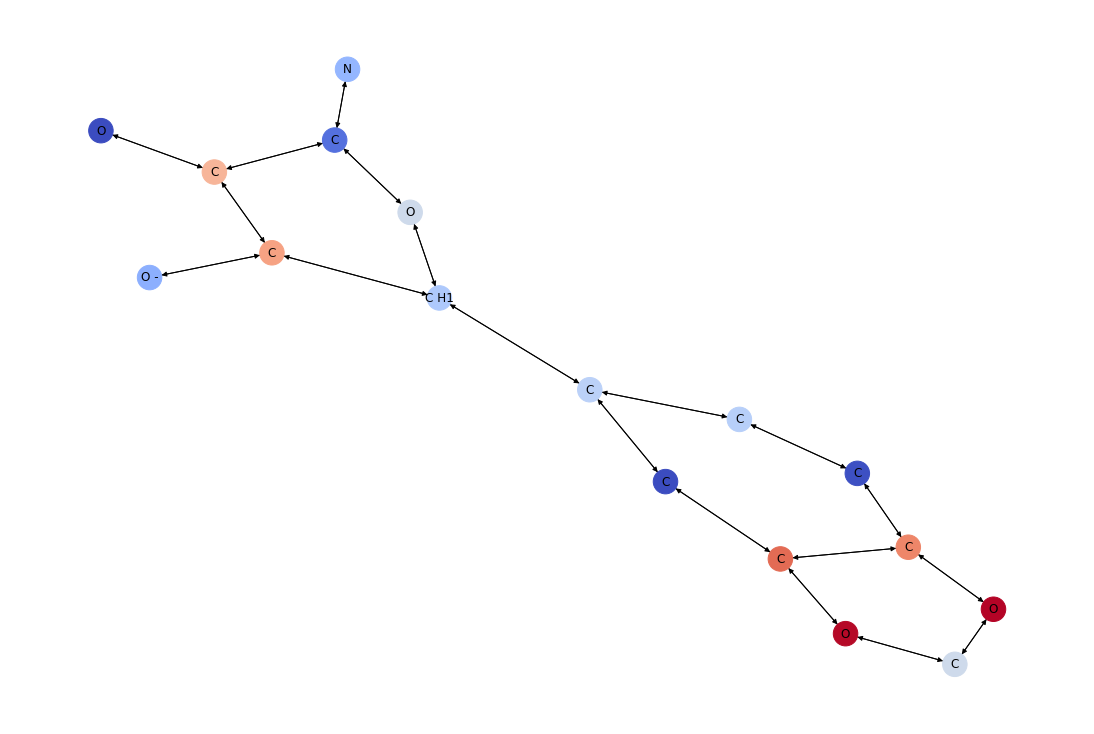


 Values of scores : 
 [21.526566    6.8289137  35.11037    27.154955   30.174385   29.30608
  1.1508332  61.859425   77.690125   34.864296   77.174484   66.29716
  0.56721944 56.610847   19.683443   52.439667    0.44978315] 

 _________ 


Expected solubility : 1.6007623672485352 .
Solubility predicted : 1.371870994567871 . 

 --------------------------------------------------




Epoch 83:  83%|████████▎ | 83/100 [19:04<03:50, 13.55s/it, lr=0.0007, test_MAE=0.347, time=13.4, train_MAE=0.195, train_loss=0.195, val_MAE=0.343, val_loss=0.343]

Epoch    83: reducing learning rate of group 0 to 3.5000e-04.


Epoch 90:  90%|█████████ | 90/100 [20:38<02:14, 13.46s/it, lr=0.00035, test_MAE=0.316, time=13.3, train_MAE=0.132, train_loss=0.132, val_MAE=0.306, val_loss=0.306]


 @ Epoch 90 ------- 

 Showing 
 - 0th element out of 128 
 - in batch 57 out of 78



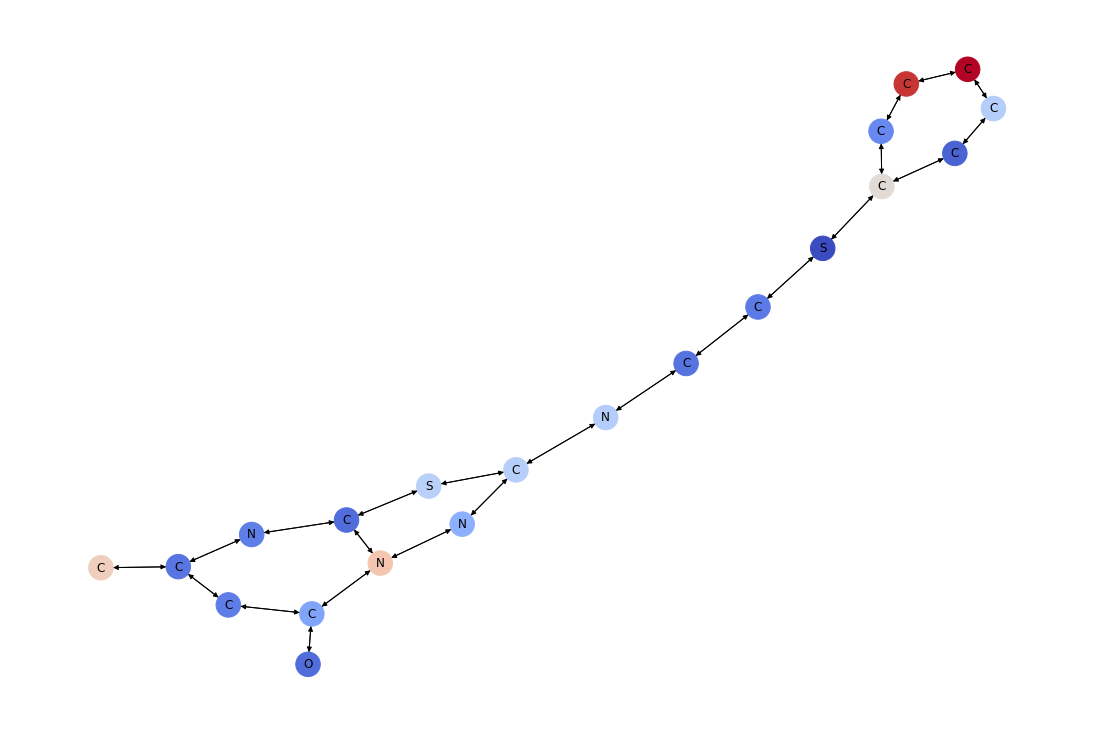


 Values of scores : 
 [58.009346  13.371357  15.179739  24.681107  11.915657  61.19242
 27.858246  38.260666  38.014416  13.333132  14.542842   4.8469114
 52.129284   9.7139225 38.009163  95.71975   91.061844  17.915485
 39.2258    11.69818   15.7311325] 

 _________ 


Expected solubility : 1.059698462486267 .
Solubility predicted : 1.036037802696228 . 

 --------------------------------------------------




Epoch 99: 100%|██████████| 100/100 [22:56<00:00, 13.76s/it, lr=0.00035, test_MAE=0.304, time=14.3, train_MAE=0.125, train_loss=0.125, val_MAE=0.315, val_loss=0.315]


Epoch   100: reducing learning rate of group 0 to 1.7500e-04.
Test MAE: 0.3045
Train MAE: 0.1136
Convergence Time (Epochs): 99.0000
TOTAL TIME TAKEN: 1400.1365s
AVG TIME PER EPOCH: 13.7219s


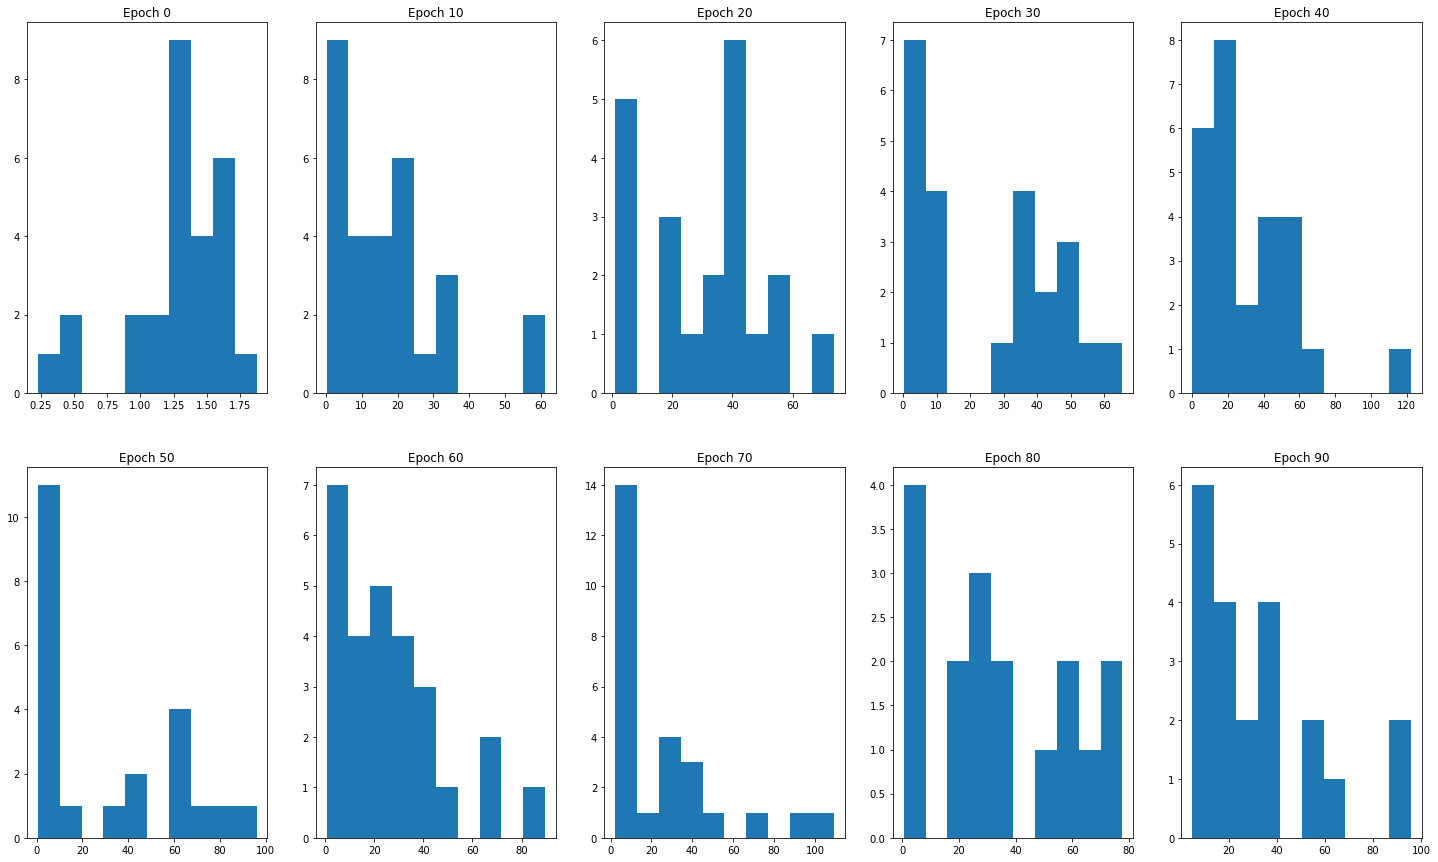

In [5]:
main()